In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from statsmodels.tsa.statespace.sarimax import SARIMAX
from itertools import product
from tqdm import tqdm_notebook


warnings.filterwarnings("ignore")

In [12]:
emissions = pd.read_csv("D:\Kuliah\BasicStats\EVEN_FinalProj\datasets\API_EN.ATM.CO2E.PC_DS2_en_csv_v2_3159114.csv", skiprows=3)
country = pd.read_csv("D:\Kuliah\BasicStats\EVEN_FinalProj\datasets\GlobalLandTemperaturesByCountry.csv")

# processing the temperature dataset to only show Indonesia
country["dt"] = pd.to_datetime(country["dt"])
country.set_index("dt", inplace=True)
indo_temp = country.loc[country["Country"] == "Indonesia"] 
indo_temp.fillna(method="bfill", inplace=True)
indo_temp.drop("AverageTemperatureUncertainty", axis=1, inplace=True)
indo_temp = indo_temp.resample("AS").mean()
indo_temp 

# processing the CO2 emissions dataset to only show Indonesia
indo_emissions = emissions.loc[emissions["Country Name"] == "Indonesia"]
indo_emissions.drop("Unnamed: 65", axis=1, inplace=True)
# dropping the NaN values as it doesn't affect the analysis
indo_emissions.drop(["2019", "2020"], axis=1, inplace=True)

# slicing the dataframe to get usable features
indo_emissions = indo_emissions.iloc[:, 4:]
indo_emissions = indo_emissions.transpose()
indo_emissions.rename(columns={106:"CO2 emissions (metric tons per capita)"}, inplace=True)
indo_emissions.index = pd.to_datetime(indo_emissions.index)
 
# combining the two datasets together
# drop rows that don't have both features
indo_final = indo_temp.merge(indo_emissions, how='inner', left_on=indo_temp.index, right_on=indo_emissions.index)

# changing the datetime column name
indo_final.rename(columns={"key_0":"datetime"}, inplace=True)
indo_final

# setting the date to be the index
indo_final.set_index("datetime", inplace=True)
indo_final

,AverageTemperature,CO2 emissions (metric tons per capita)
datetime,,
1960-01-01,26.029167,0.243920
1961-01-01,25.771667,0.288848
1962-01-01,25.789417,0.248553
1963-01-01,25.838583,0.239783
1964-01-01,25.835500,0.229458
1965-01-01,25.701750,0.246241
1966-01-01,25.943917,0.227084
1967-01-01,25.835083,0.232007
1968-01-01,25.951083,0.253602


In [13]:
# splitting the dataset into training and testing
# using a 75:15:10 ratio for the split
n = len(indo_final)
train, validation, test = indo_final[:int(n*0.75)], indo_final[int(n*0.75):int(n*0.9)], indo_final[int(n*0.9):]

In [14]:
def optimize_SARIMAX(order_list, exog, endog):
    """
        Return dataframe with parameters and corresponding AIC
        
        order_list - list with (p, d, q) tuples
        exog - the exogenous variable
    """
    
    results = []
    
    for order in tqdm_notebook(order_list):
        try: 
            model = SARIMAX(exog, endog, order=order).fit()
        except:
            continue
            
        aic = model.aic
        results.append([order, model.aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p, d, q)', 'AIC']
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [20]:
# checking the best ARIMA model
ps = range(0, 8, 1)
d = range(0, 8, 1)
qs = range(0, 8, 1)

# make a list with all possible combination of p, d, q
parameters = product(ps, qs)
parameters_list = list(parameters)

order_list = []
for parameter in parameters_list:
    parameter = list(parameter)
    parameter.insert(1, 1)
    parameter = tuple(parameter)
    order_list.append(parameter)

results_df = optimize_SARIMAX(order_list, indo_final.drop(["AverageTemperature"], axis=1), indo_final["AverageTemperature"])
results_df

  0%|          | 0/64 [00:00<?, ?it/s]

,"(p, d, q)",AIC
0,"(0, 1, 6)",-148.833640
1,"(1, 1, 5)",-148.395627
2,"(1, 1, 1)",-147.901977
3,"(1, 1, 6)",-147.298271
4,"(4, 1, 1)",-147.155826
...,...,...
59,"(7, 1, 5)",-138.477335
60,"(6, 1, 7)",-137.488074
61,"(5, 1, 7)",-137.386259
62,"(7, 1, 6)",-136.139257


In [35]:
# using the most optimal model (016)
model = SARIMAX(indo_final["AverageTemperature"], order=(0,1,6), seasonal_order=(1,1,1,12))
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                   AverageTemperature   No. Observations:                   54
Model:             SARIMAX(0, 1, 6)x(1, 1, [1], 12)   Log Likelihood                   8.260
Date:                              Thu, 13 Jan 2022   AIC                              1.480
Time:                                      08:56:34   BIC                             16.902
Sample:                                  01-01-1960   HQIC                             7.096
                                       - 01-01-2013                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8682      1.471     -0.590      0.555      -3.752       2.015
ma.L2         -0.2063      0.424     -0.487      0.626      -1.037       0.624
ma.L3          0.1368      0.301      0.455      0.649      -0.453       0.726
ma.L4          0.0405      0.225      0.180      0.857      -0.401       0.482
ma.L5         -0.1841      0.379     -0.486      0.627      -0.926       0.558
ma.L6          0.0922      0.244      0.378      0.706      -0.386       0.570
ar.S.L12      -0.1848      0.393     -0.470      0.638      -0.956       0.586
ma.S.L12      -0.4832      0.640     -0.755      0.450      -1.737       0.770
sigma2         0.0308      0.048      0.645      0.519      -0.063       0.124
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 3.78
Prob(Q):                              0.96   Prob(JB):                         0.15
Heteroskedasticity (H):               0.50   Skew:                             0.49
Prob(H) (two-sided):                  0.20   Kurtosis:                         4.11
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

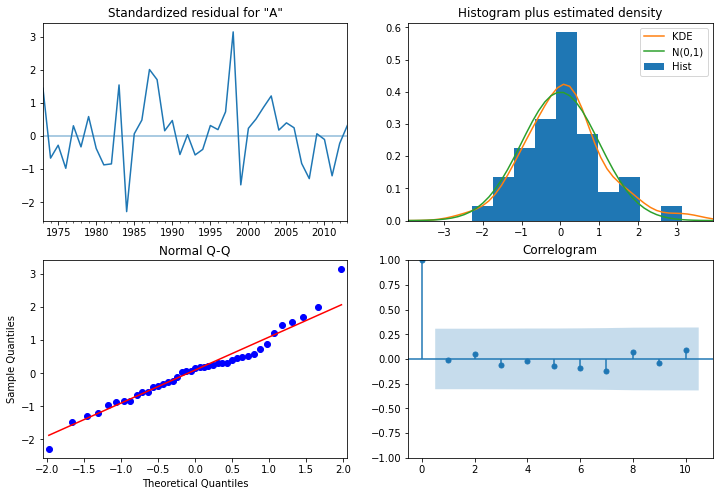

In [36]:
# residuals plot
model_fit.plot_diagnostics(figsize=(12, 8))
plt.show()

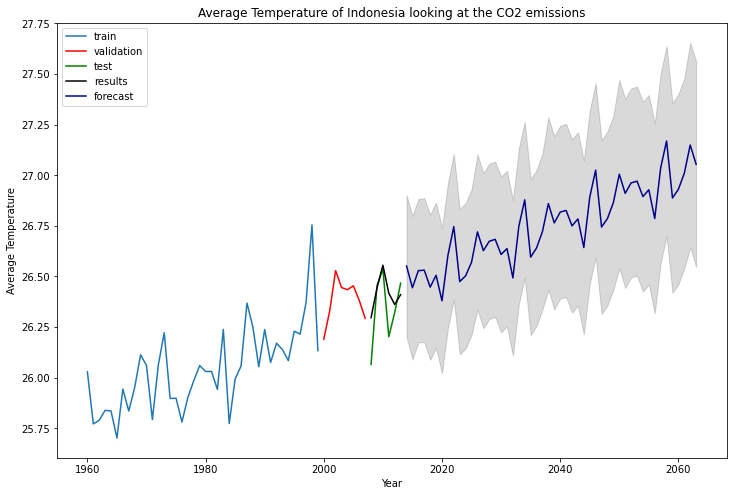

In [64]:
# plotting the in-sample prediction
results = model_fit.predict(start=int(n*0.9))
forecast = model_fit.get_forecast(steps=50)
conf_int = forecast.conf_int(alpha=0.05)
out_of_sample = forecast.predicted_mean

# confidence intervals
lower_bound = pd.Series(conf_int.iloc[:,0])
upper_bound = pd.Series(conf_int.iloc[:,1])

plt.figure(figsize=(12, 8))
plt.plot(train["AverageTemperature"], label="train")
plt.plot(validation["AverageTemperature"], label="validation", color="red")
plt.plot(test["AverageTemperature"], label="test", color="green")
plt.plot(results, label="results", color="black")
plt.plot(out_of_sample, label="forecast", color="darkblue")
plt.fill_between(lower_bound.index, lower_bound, upper_bound, color='k', alpha=.15)
plt.title("Average Temperature of Indonesia looking at the CO2 emissions")
plt.xlabel("Year")
plt.ylabel("Average Temperature")
plt.legend(loc="upper left")

In [88]:
# regression analysis
def pred_accuracy(prediction, actual):
    mae = np.mean(np.abs(prediction-actual))
    mape = np.mean(np.abs(prediction-actual) / np.abs(actual))
    mpe = np.mean((prediction-actual)/actual)
    rmse = np.mean((prediction - actual)**2)**0.5
    return {"MAPE" : mape, "MPE" : mpe, "MAE" : mae, "RMSE" : rmse}

pred_accuracy(results.values, test["AverageTemperature"].values)

{'MAPE': 0.003652366525742802,
 'MPE': 0.0027826189199380764,
 'MAE': 0.09568090793223998,
 'RMSE': 0.1324175068335623}

[26.551687838250132, 26.444264079481815, 26.528785030331523, 26.531056009100354, 26.44732352992287, 26.506033341625127, 26.379914734146073, 26.603844217374533, 26.746423291923293, 26.474760998813373, 26.50319528330824, 26.570330563379684, 26.720199540802827, 26.627526860018726, 26.67368070546846, 26.683615654789584, 26.60868854382876, 26.637733373123538, 26.492818378413112, 26.74739068762342, 26.878775043474633, 26.595454448596847, 26.64077883332173, 26.722287735792072, 26.860111555330867, 26.764712946992596, 26.81795684714176, 26.826475531934612, 26.749921231701776, 26.784448005639867]


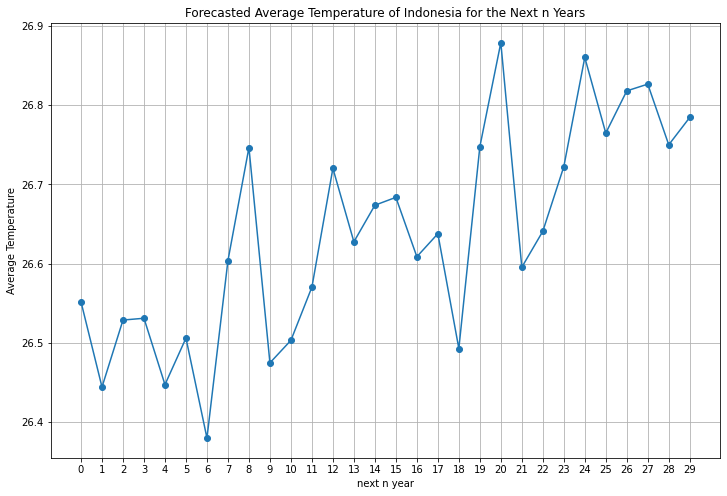

In [89]:
forecast = model_fit.forecast(steps=30, exog=indo_final["CO2 emissions (metric tons per capita)"])
forecast_values = []
for value in forecast:
    forecast_values.append(value)

plt.figure(figsize=(12, 8)) 
plt.plot(range(0, len(forecast_values)), forecast_values, marker="o")
plt.xticks(range(0, len(forecast_values)))
plt.xlabel("next n year")
plt.ylabel("Average Temperature")
plt.title("Forecasted Average Temperature of Indonesia for the Next n Years")
plt.grid()
print(forecast_values)

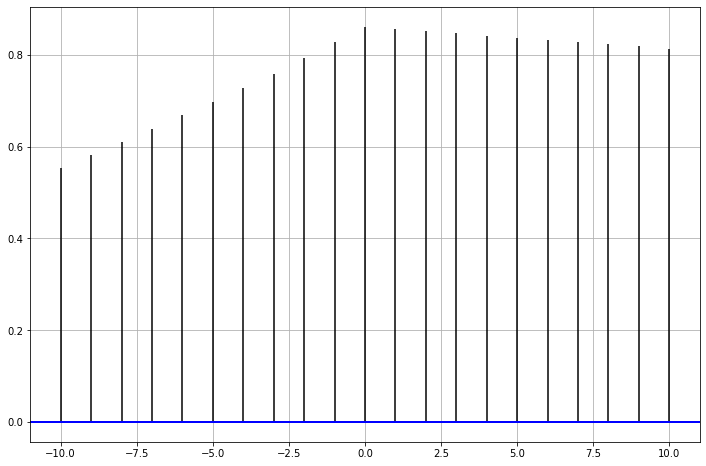

In [113]:
# plotting the cross correlation function between the time series
plt.figure(figsize=(12, 8))
plt.xcorr(indo_final["CO2 emissions (metric tons per capita)"], indo_final["AverageTemperature"], usevlines=True, normed=True, color="black")
plt.grid(True)
plt.axhline(0, color="blue", lw=2)